In [1]:
import os
import rpy2
import logging
import warnings
import anndata2ri
import pandas as pd
import scanpy as sc
import anndata as ad
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from matplotlib.pyplot import rcParams

# **Label transfer using Harmony and Liger**

In this notebook, we transfer cluster annotations from the **[Gazestani et. al. 2019](https://doi.org/10.1016/j.cell.2023.08.005) (Prefrontal Cortex)** dataset to other datasets not originally presented in the work. In particular, the SEA-AD Data from **[Gabitto et. al. 2023](https://www.biorxiv.org/content/10.1101/2023.05.08.539485v3) (Middle Temporal Gyrus)**.  

This pipeline (and markdown) was orginally provided in **[Gazestani et. al. 2019](https://doi.org/10.1016/j.cell.2023.08.005)**. The provided functions perform the label transfer using a propagation method where cell annotations from the is propagated to another based on the PC space. Therefore, for optimal performance, we need to first perform batch correction of the PCA space. We have provided functionality to do batch correction using either Harmony `.myLabelTransfer_harmony()` or Liger `.myLabelTransfer_liger()`. In cases that two datasets are already aligned, we can use `.myLabelTransfer_aligned()` function.  
  
We employ the label propagation methods suitable for reference and query datasets that are from the same organism (Human).

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

warnings.filterwarnings("ignore", category=PendingDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# rcParams['figure.dpi'] = get_sys_dpi(1512, 982, 14.125)
#rcParams['figure.figsize']=(4,4) #rescale figures

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()


-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.5.0
anndata2ri                  1.1
appnope                     0.1.3
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
comm                        0.1.3
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
executing                   1.2.0
google                      NA
h5py                        3.9.0
igraph                      0.10.4
ipykernel                   6.23.2
ipywidgets                  8.0.6
jedi                        0.18.2
jinja2                      3.1.2
joblib                      1.2.0
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite                    0.39.1
louvain                     0.8.0
markupsafe                  2.1.3
matplotlib                  3.7.1
mpl_toolkits                NA
natsort 

In [3]:
%%R
suppressPackageStartupMessages({
    library(harmony)
    library(rliger)
# needs to be run every time you start R and want to use %>%
})

source("../scripts/functions/deg_functions/sconline_code.R")

delete_file <- function(file_path) {
  if (file.exists(file_path)) {
    file.remove(file_path)
    cat("File deleted successfully.\n")
  } else {
    cat("File does not exist.\n")
  }
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Main Functions:
.myRead10X()
.myRead10X_h5()
.myLigerToExpSet()
.mycBindFn()
.myExpSetCreatorFn()
.myIntegrative_oneline()
.myFindAllMarkers()
.myAnnotateFn()
.my2dPlot()
.myPseudoCellfn_v2()
.myLabelTransfer_harmony()
.myLabelTransfer_liger()
.myMapToHuman()
.myRiverPlotFn()
.myClusteringOptimizerFn()
.myMarkerBasedAnalysisFn()
.mycellAssignHeatmap()
.myMetaMarkerFn()
.myFindNeighbors()
.myVlnPlot()
.myFeaturePlot()
.myheatmap.3()
.myEvalMarkers()
.myReadGMT()
.mySplitObject()
.myRTNgsea(two-sided GSEA implementation)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
Attaching SeuratObject
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘matrixStats’

The following object is masked from ‘package:dplyr’:

    count

The f

# **Transferring annotations between two human datasets**

  To perform label transfer, we need to pass certain inputs into the label transfer function.

The main input arguments to the label transfer functions:  
* **dataset_source:** the dataset with cell type annotations (SingleCellExperiment)  

* **dataset_target**: the dataset that we want to transfer the labels to (SingleCellExperiment)  

* **source_label_col:** The column in the source dataset that has the cell type annotations  

* **indScaling:** Only in label transfer by harmony (`.myLabelTransfer_harmony()`). do independent scaling for PCA to reduce batch effects? 

* **ds_specific_hvg:** Include dataset specific highly variable genes? it depends if you expect cell types that are specific to source or the target datasets. default TRUE.

* **target_label_col:** Cell label annotations for the target dataset. Useful if you want to create confusion matrix between source and querry datasets. default NULL.  

* **source_batch_label_col:** Useful if the source dataset is composed of multiple batches. default NULL.  

* **target_batch_label_col:** Useful if the target dataset is composed of multiple batches. default NULL. 

* **covariates:** covariates other than dataset (e.g., source and target) that contribute to batch effects and should be accounted for. default NULL.  

* **prenatalDataset:** Whether one of the datasets is from prenatal. default FALSE. 

* **nPCs:** Number of PCs. default 30. 

To perform label transfer using Harmony:

In [4]:
#reference and query dataset
cell_type = 'excitatory'
target = 'leng_sfg'

data_source=sc.read_h5ad(f'../data/raw/gazestani_pfc/anndata/{cell_type}_raw_anndata.h5ad') 
data_target=sc.read_h5ad(f'../data/raw/{target}/anndata/{cell_type}_raw_anndata.h5ad')


obs_to_keep = ['clusters']
var_to_keep = ['gene_id', 'gene_name', 'ensembl_gene_id']

for col in data_source.obs.columns:
    if col not in obs_to_keep:
        del data_source.obs[col]
        
for col in data_source.var.columns:
    if col not in var_to_keep:
        del data_source.var[col]


In [6]:
%%R -i data_source -i data_target

counts(data_source) <- assay(data_source, "X") # set counts assay to data in X
assay(data_source, "X") <- NULL # free X

counts(data_target) <- assay(data_target, "X") # set counts assay to data in X
assay(data_target, "X") <- NULL # free X

data_target$cell_subtype = 'NA' # creaste column for saving results


The first thing we need to handle is matching of the gene names between the two datasets. 

In many cases, the gene names are not compatible. We will used the `.extraHumanGeneAnnoAdderFn()` function to add further information about the genes:

In [7]:
%%R

# Here we don't actually add the gene anno to the source object since they are already added
gn_anno_source = .extraHumanGeneAnnoAdderFn(inputGeneNames=row.names(data_source))
gn_anno_source = gn_anno_source[match(row.names(data_source),gn_anno_source$gene_id),]
if(!all(gn_anno_source$gene_id==row.names(data_source),na.rm=F)){
    stop("Error in matching the gene names of the source dataset")
}
# rowData(data_source)=cbind(rowData(data_source),gn_anno_source)

gn_anno_target = .extraHumanGeneAnnoAdderFn(inputGeneNames=row.names(data_target))
gn_anno_target = gn_anno_target[match(row.names(data_target),gn_anno_target$gene_id),]
rowData(data_target) = cbind(rowData(data_target),gn_anno_target)
if(!all(gn_anno_source$gene_id==row.names(data_source),na.rm=F)){
    stop("Error in matching the gene names of the target dataset")
}

target_cols <- c("seqnames", "ranges", "strand", "start", "end", "width", "element")
rowData(data_target) <- rowData(data_target)[, -which(names(rowData(data_target)) %in% target_cols)]

Now we can change the gene names (rownames) of the two datasets to ensembl_gene_id, so the two datases match

In [8]:
%%R 

#we first genes with no ensembl_gene_id
data_source=data_source[!is.na(rowData(data_source)$ensembl_gene_id),]
data_target=data_target[!is.na(rowData(data_target)$ensembl_gene_id),]

# Second, we remove the genes w duplicate ensemble_gene_ids
print(paste("Removing duplicated gene names:", sum(duplicated(rowData(data_source)$ensembl_gene_id)),"genes from the source and", sum(duplicated(rowData(data_target)$ensembl_gene_id)),"from the target dataset."))
data_source=data_source[!duplicated(rowData(data_source)$ensembl_gene_id),]
data_target=data_target[!duplicated(rowData(data_target)$ensembl_gene_id),]

# Third, we convert the gene names to ensembl gene ids
row.names(data_source)=rowData(data_source)$ensembl_gene_id
row.names(data_target)=rowData(data_target)$ensembl_gene_id

print(paste("Number of genes in common between the two datasets", length(intersect(row.names(data_source),row.names(data_target)))))

#Lastly, we only include genes that are 
data_source=data_source[which(row.names(data_source) %in% row.names(data_target)),]
data_target=data_target[which(row.names(data_target) %in% row.names(data_source)),]


[1] "Removing duplicated gene names: 16 genes from the source and 2 from the target dataset."
[1] "Number of genes in common between the two datasets 30249"


## **label propagation using Harmony**

In [9]:
%%R

# matching the row.names between the two datasets
data_source = data_source[match(row.names(data_target), row.names(data_source)),]


# running harmony label transfer function
res_prop_harmony=.myLabelTransfer_harmony(dataset_source = data_source, 
                                        dataset_target = data_target,
                                        indScaling=T,
                                        return_seurat_obj=T,
                                        ds_specific_hvg = T,
                                        source_label_col = "clusters",
                                        target_label_col = 'cell_subtype',
                                        covariates = NULL,
                                        source_batch_label_col = NULL,
                                        target_batch_label_col = 'SampleBatch',
                                        calculate_depth_per_gene = F)


[1] "Combining the datasets..."
[1] "batch information is in the anno_batch variable"
Loading required package: ggalluvial
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Error: vector memory exhausted (limit reached?)


RInterpreterError: Failed to parse and evaluate line '\n# matching the row.names between the two datasets\ndata_source = data_source[match(row.names(data_target), row.names(data_source)),]\n\n\n# running harmony label transfer function\nres_prop_harmony=.myLabelTransfer_harmony(dataset_source = data_source, \n                                        dataset_target = data_target,\n                                        indScaling=T,\n                                        return_seurat_obj=T,\n                                        ds_specific_hvg = T,\n                                        source_label_col = "clusters",\n                                        target_label_col = \'cell_subtype\',\n                                        covariates = NULL,\n                                        source_batch_label_col = NULL,\n                                        target_batch_label_col = \'SampleBatch\',\n                                        calculate_depth_per_gene = F)\n'.
R error message: 'Error: vector memory exhausted (limit reached?)'
R stdout:
Loading required package: ggalluvial
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Error: vector memory exhausted (limit reached?)

: 

Exploring the results

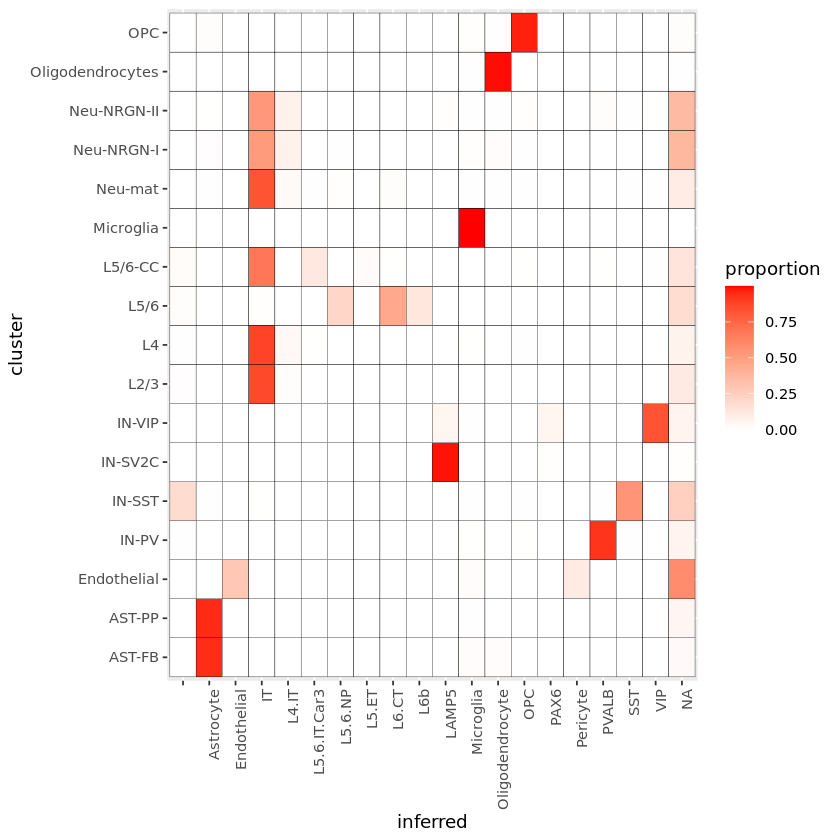

In [7]:
%%R

#The following visualization works only if target_label_col is provided
#only estimates with confidence level >0.8 are represented, otherwise NA
.mycellAssignHeatmap_binary(input_labelTransfer_object=res_prop_harmony,confidenceLevel=0.8,target_cluster_col="cluster")

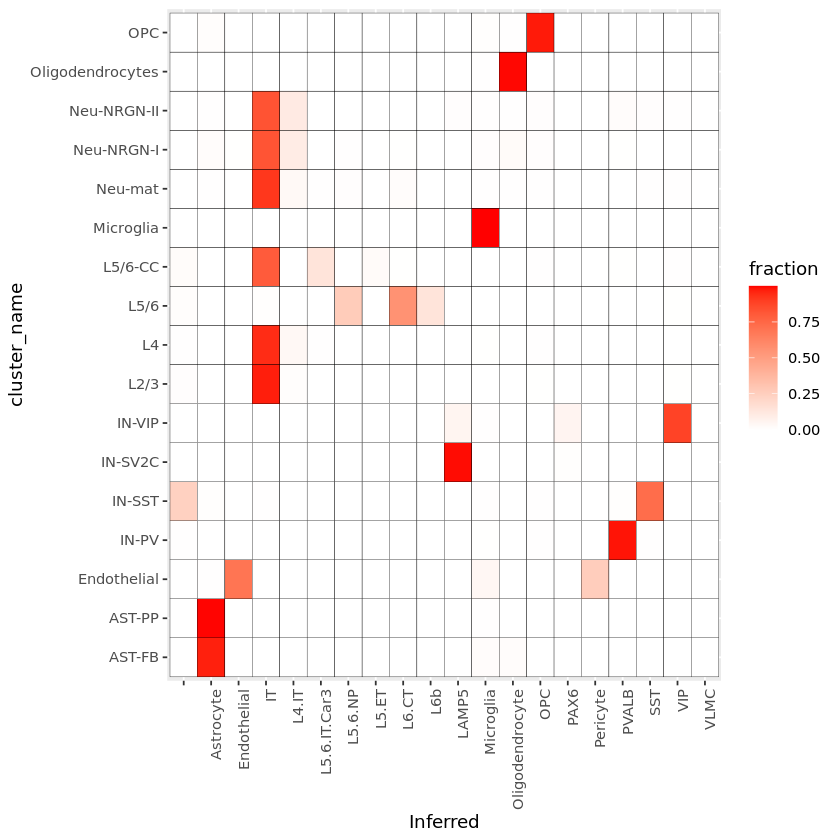

In [8]:
#probabilistic assignments
.mycellAssignHeatmap_prob(input_labelTransfer_object=res_prop_harmony,target_cluster_col="cluster")

In [9]:
head(res_prop_harmony$test_labels)

,orig.ident,nCount_RNA,nFeature_RNA,sample_name,exp_component_name,specimen_type,cluster_color,cluster_order,cluster_label,class_color,⋯,inferred_LAMP5,inferred_Microglia,inferred_Oligodendrocyte,inferred_OPC,inferred_PAX6,inferred_Pericyte,inferred_PVALB,inferred_SST,inferred_VIP,inferred_VLMC
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
target_target_AAACCTGGTACGCACC_1_1823_BA24,SeuratProject,2381.963,597,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.00,0.000,0,0,0,0,0,0
target_target_AAACGGGCACCAGATT_1_1823_BA24,SeuratProject,5924.242,6080,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.00,0.000,0,0,0,0,0,0
target_target_AAAGATGAGTCCAGGA_1_1823_BA24,SeuratProject,2285.654,580,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.96,0.000,0,0,0,0,0,0
target_target_AAAGATGTCTTGAGGT_1_1823_BA24,SeuratProject,3261.971,1080,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.00,0.978,0,0,0,0,0,0
target_target_AAAGCAAGTAATCACC_1_1823_BA24,SeuratProject,2436.376,641,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.98,0.000,0,0,0,0,0,0
target_target_AAAGCAAGTTGCCTCT_1_1823_BA24,SeuratProject,2391.185,615,NA,NA,NA,NA,NA,NA,NA,⋯,0,0,0.00,0.000,0,0,0,0,0,0


columns starting with `inferred_` represent the probability of each cell be of a given cell type annotation.  

Visualizing the inferred labels

In [ ]:
data_obj=res_prop_harmony$seurat_obj
Idents(data_obj)=data_obj$anno
DimPlot(data_obj)

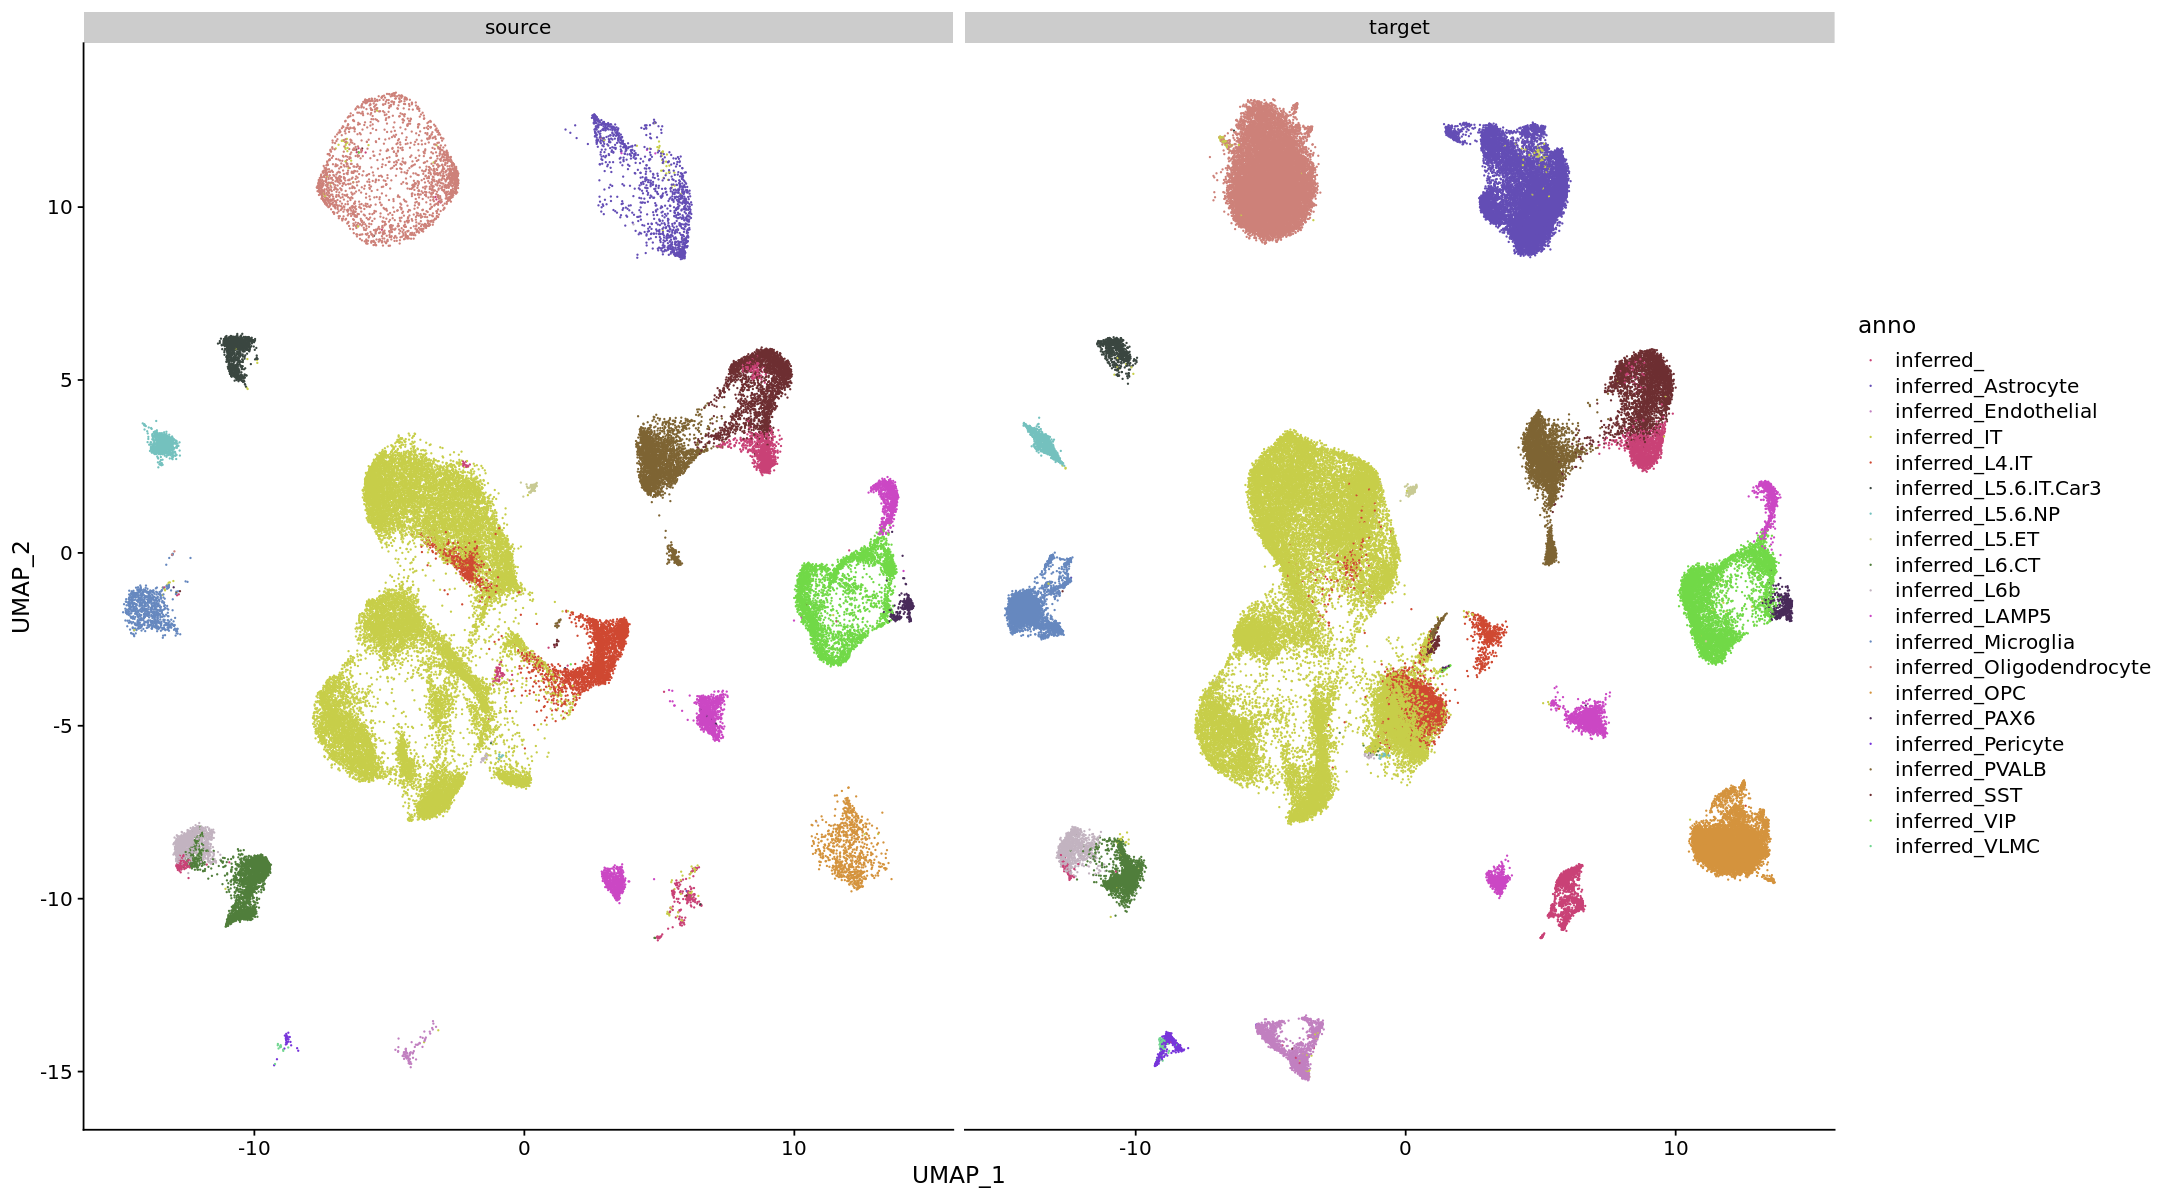

In [11]:
options(repr.plot.width=18, repr.plot.height=10)

DimPlot(data_obj,split.by ="batch_label")

we can use `.myLabelTransfer_liger()` function to similarly transfer labels from source to target using LIGER

# Label transfer between humand and mouse datasets

The main difference in this setting is the need to convert mouse gene names to human genes. We have a function in scOnline for this conversion:

In [12]:
#inputData is the mouse SCE object
#gene_names_converted_to_human=.myMapToHuman(inputData,server=T,conservativeMapping=F,oldMapping=F,MGIsymbol=T)

the rest of the steps are same as before

# Label transfer between two aligned datasets

We use `.myLabelTransfer_aligned()` function to transfer labels between two aligned datasets. the main arguments for this function are:  
* **pca_source:** aligned pc space of the source dataset  
* **meta_source**: meta.data for the source dataset  
* **pca_target:** aligned pc space for the target dataset  
* **meta_target:** meta.data for the target dataset  
* **source_label_col:** cell label annotations for the source dataset.  
* **target_label_col:** Cell label annotations for the target dataset. Useful if you want to create confusion matrix between source and querry datasets. default NULL.  
* **nPCs:** Number of PCs to use. if NULL, sets to ncol(pca_source). 

In [18]:
#we use the harmony space in res_prop_harmony to run this function
pca_combined=res_prop_harmony$harmony_embeddings
pca_source=pca_combined[grepl("^source\\_",row.names(pca_combined)),]
pca_target=pca_combined[grepl("^target\\_",row.names(pca_combined)),]

row.names(pca_source)=gsub("source\\_","",row.names(pca_source))
row.names(pca_target)=gsub("target\\_","",row.names(pca_target))

#matching the pca and meta data for each dataset
pca_source=pca_source[match(colnames(data_source),row.names(pca_source)),]
pca_target=pca_target[match(colnames(data_target),row.names(pca_target)),]

#preliminary check of the pca and meta data
if(sum(is.na(pca_source))>0){
    stop("Error in source")
}

if(sum(is.na(pca_target))>0){
    stop("Error in target")
}


meta_source=as.data.frame(colData(data_source))
meta_target=as.data.frame(colData(data_target))


In [69]:
#Running the propagation algorithm
res_aligned=.myLabelTransfer_aligned(pca_source=pca_source,meta_source=meta_source,pca_target=pca_target,meta_target=meta_target,source_label_col="subclass_label",target_label_col="cluster",nPCs=NULL)


[1] 1
[1] 2
[1] 3


In [75]:
#comparing the results between res_aligned and res_prop_harmony

sl_cols=colnames(res_prop_harmony$combined_labels)[grepl("^inferred\\_",colnames(res_prop_harmony$combined_labels))]
anno_harmony=apply(res_prop_harmony$combined_labels[,sl_cols],1,function(x) sl_cols[which(x==max(x,na.rm=T))[1]])
anno_aligned=apply(res_aligned$combined_labels[,sl_cols],1,function(x) sl_cols[which(x==max(x,na.rm=T))[1]])

names(anno_harmony)=row.names(res_prop_harmony$combined_labels)
names(anno_harmony)=gsub("source\\_","",names(anno_harmony))
names(anno_harmony)=gsub("target\\_","",names(anno_harmony))

names(anno_aligned)=row.names(res_aligned$combined_labels)
anno_aligned=anno_aligned[match(names(anno_harmony),names(anno_aligned))]

table(anno_aligned==anno_harmony)


  TRUE 
153976 

Similar to above, we can generate visualizations of the results

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'"
19:53:13 UMAP embedding parameters a = 0.9922 b = 1.112

19:53:13 Read 153976 rows and found 30 numeric columns

19:53:13 Using Annoy for neighbor search, n_neighbors = 30

19:53:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:53:45 Writing NN index file to temp file /tmp/RtmpT7p3rD/filec6c7656a430

19:53:45 Searching Annoy index using 1 thread, search_k = 3000

19:55:19 Annoy recall = 100%

19:55:21 Commencing smooth kNN distance calibration using 1 thread

19:55:28 Initializing from normalized Laplacian + noise

19:57:59 Co

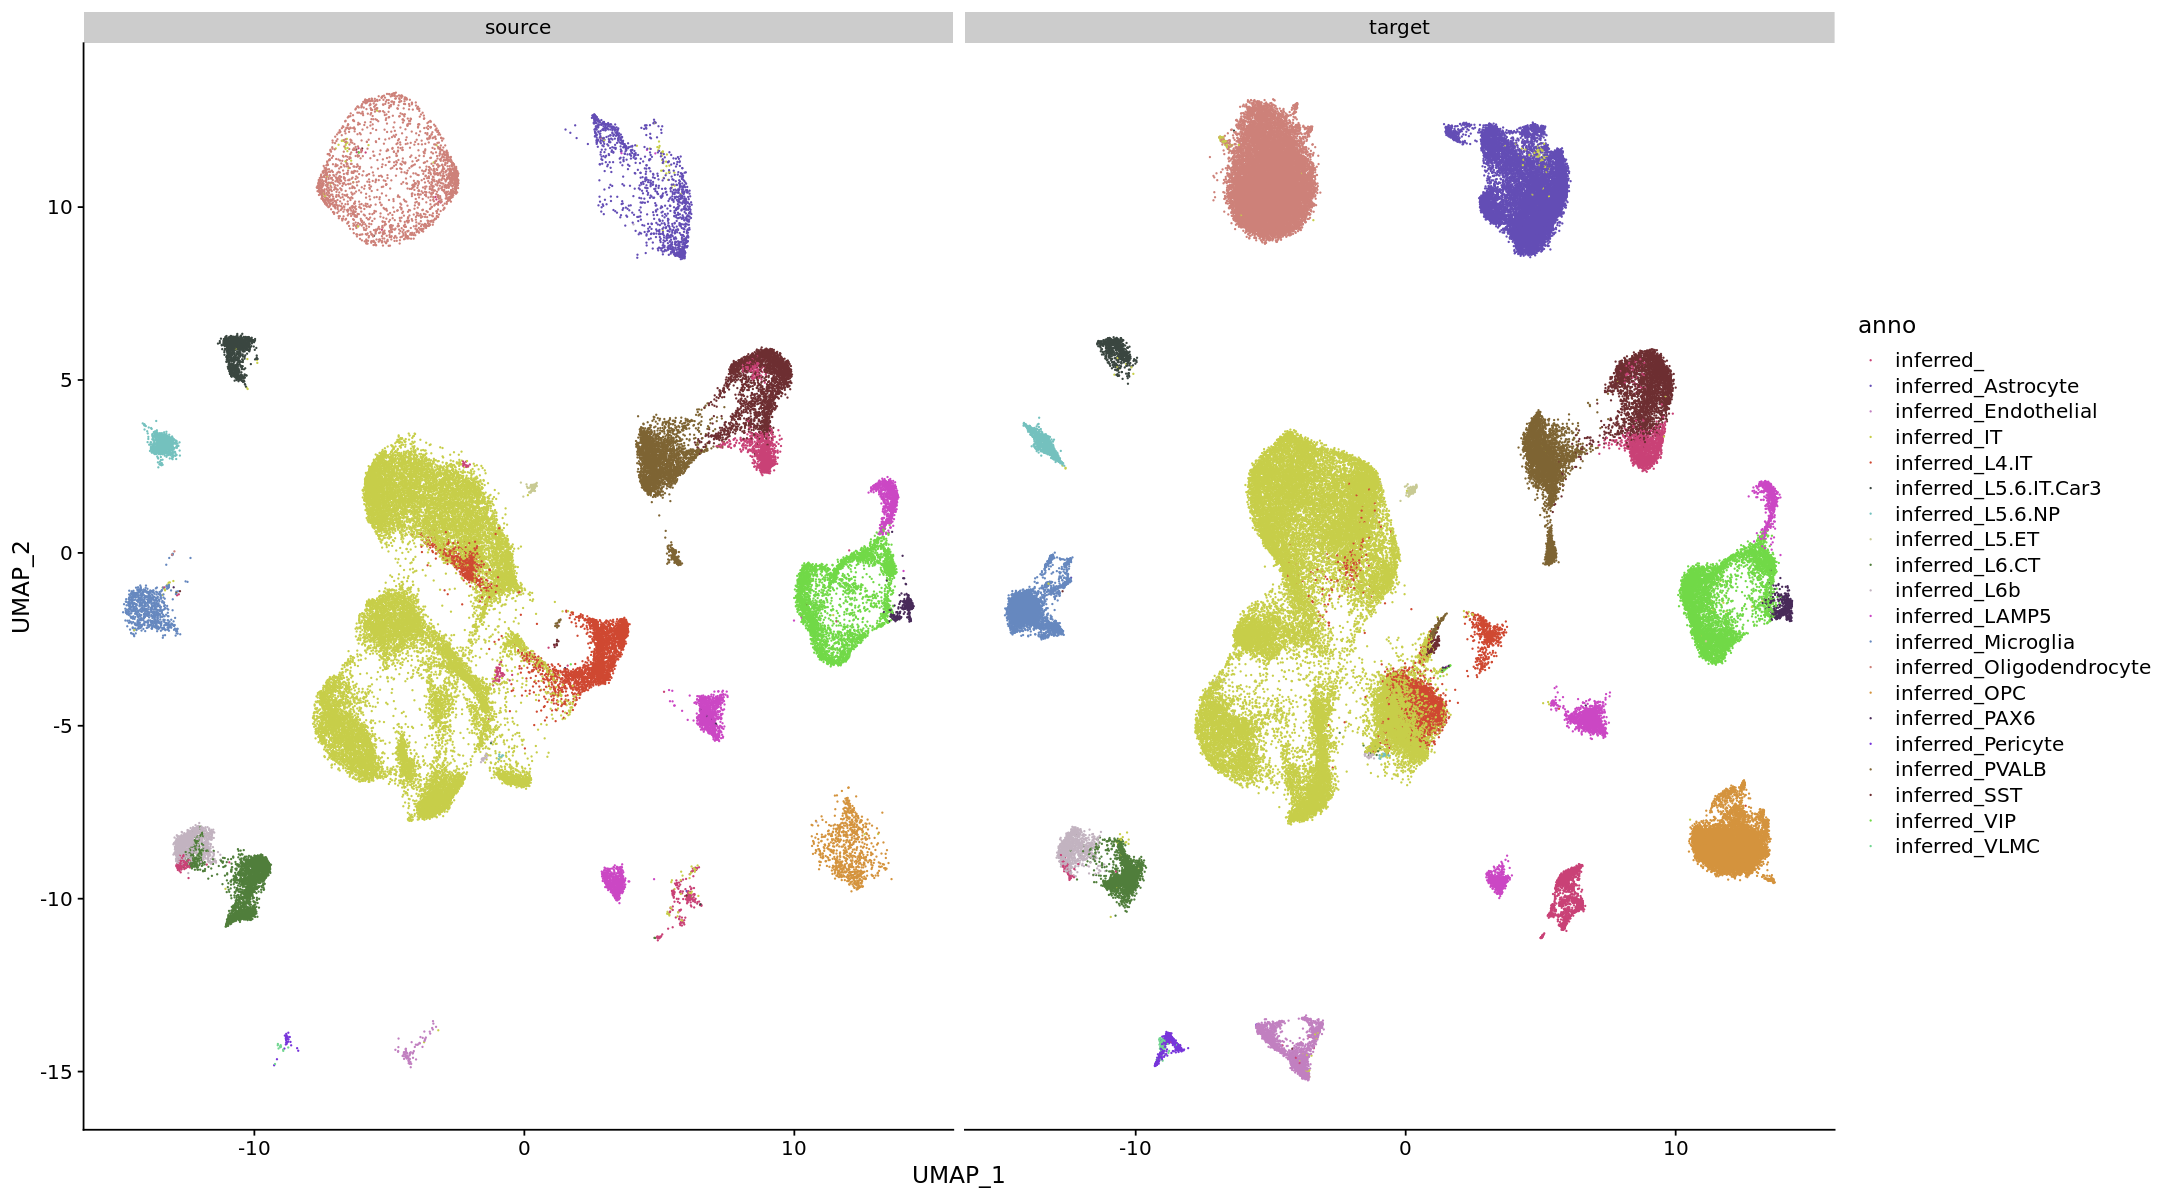

In [77]:
options(repr.plot.width=18, repr.plot.height=10)
data_obj=res_prop_harmony$seurat_obj
Idents(data_obj)=data_obj$anno
DimPlot(data_obj,split.by ="batch_label")


# Azimuth references

We first need to install required libraries:

In [2]:
devtools::install_github("satijalab/seurat-data")
devtools::install_github("satijalab/azimuth")

crayon (1.5.1 -> 1.5.2) [CRAN]
cli    (3.4.1 -> 3.6.0) [CRAN]


Installing 2 packages: crayon, cli

Installing packages into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/RtmpFcawwZ/remotesa95e936af6/satijalab-seurat-data-d6a8ce6/DESCRIPTION’ ... OK
* preparing ‘SeuratData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratData_0.2.2.tar.gz’



Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)




presto       (NA         -> 045390ae5...) [GitHub]
SeuratDisk   (NA         -> 9b89970ea...) [GitHub]
utf8         (1.2.2      -> 1.2.3       ) [CRAN]
fansi        (1.0.3      -> 1.0.4       ) [CRAN]
vctrs        (0.5.0      -> 0.5.2       ) [CRAN]
stringi      (1.7.8      -> 1.7.12      ) [CRAN]
stringr      (1.4.0      -> 1.5.0       ) [CRAN]
purrr        (0.3.5      -> 1.0.1       ) [CRAN]
dplyr        (1.0.10     -> 1.1.0       ) [CRAN]
fs           (1.5.2      -> 1.6.1       ) [CRAN]
digest       (0.6.29     -> 0.6.31      ) [CRAN]
sass         (0.4.2      -> 0.4.5       ) [CRAN]
jsonlite     (1.8.0      -> 1.8.4       ) [CRAN]
htmltools    (0.5.3      -> 0.5.4       ) [CRAN]
Rcpp         (1.0.9      -> 1.0.10      ) [CRAN]
BH           (1.78.0-0   -> 1.81.0-1    ) [CRAN]
RcppAnnoy    (0.0.19     -> 0.0.20      ) [CRAN]
polyclip     (1.10-0     -> 1.10-4      ) [CRAN]
spatstat.... (2.3-1      -> 3.0-1       ) [CRAN]
spatstat.... (2.2-0      -> 3.0-0       ) [CRAN]
spatstat.... (2.

vctrs        (0.5.0      -> 0.5.2     ) [CRAN]
stringi      (1.7.8      -> 1.7.12    ) [CRAN]
utf8         (1.2.2      -> 1.2.3     ) [CRAN]
fansi        (1.0.3      -> 1.0.4     ) [CRAN]
Rcpp         (1.0.9      -> 1.0.10    ) [CRAN]
stringr      (1.4.0      -> 1.5.0     ) [CRAN]
purrr        (0.3.5      -> 1.0.1     ) [CRAN]
dplyr        (1.0.10     -> 1.1.0     ) [CRAN]
RcppArmad... (0.11.4.0.1 -> 0.11.4.3.1) [CRAN]
tidyr        (1.2.1      -> 1.3.0     ) [CRAN]
data.table   (1.14.2     -> 1.14.6    ) [CRAN]


Installing 11 packages: vctrs, stringi, utf8, fansi, Rcpp, stringr, purrr, dplyr, RcppArmadillo, tidyr, data.table

Installing packages into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/RtmpFcawwZ/remotesa97a09363/immunogenomics-presto-045390a/DESCRIPTION’ ... OK
* preparing ‘presto’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘presto_1.0.0.tar.gz’



Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)




BH           (1.78.0-0  -> 1.81.0-1 ) [CRAN]
RcppAnnoy    (0.0.19    -> 0.0.20   ) [CRAN]
polyclip     (1.10-0    -> 1.10-4   ) [CRAN]
spatstat.... (2.3-1     -> 3.0-1    ) [CRAN]
spatstat.... (2.2-0     -> 3.0-0    ) [CRAN]
spatstat.... (2.1-1     -> 3.0-0    ) [CRAN]
spatstat.... (2.2-0     -> 3.1-3    ) [CRAN]
spatstat.... (2.4-0     -> 3.0-6    ) [CRAN]
fs           (1.5.2     -> 1.6.1    ) [CRAN]
digest       (0.6.29    -> 0.6.31   ) [CRAN]
sass         (0.4.2     -> 0.4.5    ) [CRAN]
bslib        (0.4.0     -> 0.4.2    ) [CRAN]
commonmark   (1.8.0     -> 1.8.1    ) [CRAN]
sourcetools  (0.1.7     -> 0.1.7-1  ) [CRAN]
htmltools    (0.5.3     -> 0.5.4    ) [CRAN]
fontawesome  (0.3.0     -> 0.5.0    ) [CRAN]
jsonlite     (1.8.0     -> 1.8.4    ) [CRAN]
httpuv       (1.6.5     -> 1.6.8    ) [CRAN]
parallelly   (1.32.1    -> 1.34.0   ) [CRAN]
listenv      (0.8.0     -> 0.9.0    ) [CRAN]
globals      (0.16.0    -> 0.16.2   ) [CRAN]
RcppEigen    (0.3.3.9.2 -> 0.3.3.9.3) [CRAN]
progressr 

Installing 62 packages: BH, RcppAnnoy, polyclip, spatstat.utils, spatstat.data, spatstat.sparse, spatstat.random, spatstat.geom, fs, digest, sass, bslib, commonmark, sourcetools, htmltools, fontawesome, jsonlite, httpuv, parallelly, listenv, globals, RcppEigen, progressr, future.apply, future, sp, colorspace, plyr, isoband, matrixStats, gtools, png, RcppTOML, sys, tinytex, xfun, highr, evaluate, openssl, curl, rmarkdown, knitr, yaml, htmlwidgets, httr, shiny, zoo, igraph, reticulate, bit, uwot, spatstat.explore, SeuratObject, sctransform, plotly, pbapply, patchwork, leiden, ggridges, ggrepel, Seurat, hdf5r

Installing packages into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

also installing the dependency ‘Matrix’




* checking for file ‘/tmp/RtmpFcawwZ/remotesa941150d57/mojaveazure-seurat-disk-9b89970/DESCRIPTION’ ... OK
* preparing ‘SeuratDisk’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratDisk_0.0.0.9020.tar.gz’



Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)

Installing 102 packages: utf8, fansi, vctrs, stringi, stringr, purrr, dplyr, fs, digest, sass, jsonlite, htmltools, Rcpp, BH, RcppAnnoy, polyclip, spatstat.utils, spatstat.data, spatstat.sparse, spatstat.random, spatstat.geom, bslib, commonmark, sourcetools, fontawesome, httpuv, parallelly, listenv, globals, RcppEigen, progressr, future.apply, future, sp, colorspace, plyr, isoband, RcppArmadillo, matrixStats, gtools, png, RcppTOML, sys, tinytex, xfun, highr, evaluate, openssl, curl, rmarkdown, knitr, yaml, data.table, tidyr, htmlwidgets, httr, shiny, zoo, igraph, reticulate, bit, rstudioapi, gargle, IRanges, S4Vectors, MatrixGenerics, BiocGenerics, DelayedArray, zlibbioc, GenomeInfoDbData, RCurl, Biobase, XVector, GenomeInfoDb, GenomicRanges, SummarizedExperiment, Rhdf5lib, rhdf5filters, rhdf5, sparseMatrixStats, uwot, spatstat.explore, SeuratObject, sctransform, plotly, pbapply, patchwork, leiden, ggridges, gg

* checking for file ‘/tmp/RtmpFcawwZ/remotesa9223e1cc4/satijalab-azimuth-fa45d4c/DESCRIPTION’ ... OK
* preparing ‘Azimuth’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘Azimuth_0.4.6.tar.gz’



Installing package into ‘/home/jupyter/packages’
(as ‘lib’ is unspecified)



In [3]:
library(Seurat)
library(Azimuth)
library(SeuratData)

ERROR: Error: package or namespace load failed for ‘Seurat’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace ‘vctrs’ 0.5.0 is already loaded, but >= 0.5.2 is required


Getting the list of available reference datasets from Azimuth

In [ ]:
available_data <- AvailableData()
available_data[grep("Azimuth", available_data[, 3]),]

We now download a dataset of our choice as source (reference):

In [ ]:
reference="humancortexref"
InstallData(reference)
# only get the `map` object since no plotting is performed
reference <- LoadData(reference, type = "azimuth")$map
reference=.myExpSetCreatorFn(inputExpData=reference,organism="Human",minExpCells=0,addExtraAnno=T,server=T,redownload_files=T,ncores=1)
class(reference)

In [ ]:
head(colData(reference))

In [78]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] caret_6.0-93                lattice_0.20-45            
 [3] ggalluvial_0.12.3           EnsDb.Hsapiens.v86_2.99.0  
 [5] ensembldb_2.20.2            AnnotationFilter_1.20.0    
 [7] GenomicFeatures_1.48.3      AnnotationDbi_1.58.0    